In [1]:
from distutils.version import LooseVersion  

import numpy as np  
import pandas as pd  #
import matplotlib.pyplot as plt 
import seaborn as sns  
from scipy.stats import linregress  

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import silhouette_score 
from sklearn.cluster import KMeans 
from sklearn import __version__ as sklearn_version
from packaging.version import parse as parse_version

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming 'sklearn_version' is defined elsewhere, if using it
from packaging.version import parse as parse_version
from sklearn import __version__ as sklearn_version

def find_outliers(column_name, df):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    
    print("Upper outlier threshold:", upper_limit)
    print("Lower outlier threshold:", lower_limit)
    
    outliers = df[(df[column_name] > upper_limit) | (df[column_name] < lower_limit)]
    print(f'There are {outliers.shape[0]} outliers.')
    
    return outliers

def clean_owner(owner):
    mapping = {'First Owner': 1, 'Second Owner': 2, 'Third Owner': 3,
               'Fourth & Above Owner': 4, 'Test Drive Car': 0}
    return mapping.get(owner, -999)

def clean_owner_year(data):
    data['owner'] = data['owner'].apply(clean_owner)
    data['year'] = data['year'] - 2000
    return data

def cluster_and_plot(columns, df):
    X = df[columns]
    best_score, best_n_clusters = -1, 0
    
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=5)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        
        if score > best_score:
            best_score, best_n_clusters = score, n_clusters

    print("Optimal number of clusters:", best_n_clusters)
    kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=5)
    labels = kmeans.fit_predict(X)
    
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.xlabel(columns[0])
    plt.ylabel(columns[1])
    plt.colorbar(label='Cluster')
    plt.show()
    
    return labels

def drop_unnecessary_cols(data):
    unnecessary_cols = ['Unnamed: 0', 'max_power (in bph)', 'Mileage Unit']
    return data.drop(unnecessary_cols, axis=1, errors='ignore')

def clean_outliers(data):
    km_outliers = find_outliers('km_driven', df=data)
    data.loc[km_outliers.index, 'km_driven'] = 172500
    return data

global_scaler = StandardScaler()
global_encoder = OneHotEncoder()

def get_feature_names(encoder, input_features):
    if parse_version(sklearn_version) >= parse_version("1.0"):
        return encoder.get_feature_names_out(input_features)
    return encoder.get_feature_names(input_features)

def fit_train_standard_scaler_encoder(data):
    data[['km_driven']] = global_scaler.fit_transform(data[['km_driven']])
    categorical_features = ['name', 'fuel', 'seller_type']
    encoded_features = global_encoder.fit_transform(data[categorical_features]).toarray()
    data = data.drop(categorical_features, axis=1)
    new_cols = get_feature_names(global_encoder, categorical_features)
    data[new_cols] = pd.DataFrame(encoded_features, index=data.index)
    return data

def standardize_new_data(data):
    data[['km_driven']] = global_scaler.transform(data[['km_driven']])
    return data

def encode_new_data(data):
    categorical_features = ['name', 'fuel', 'seller_type']
    encoded_features = global_encoder.transform(data[categorical_features]).toarray()
    data = data.drop(categorical_features, axis=1)
    new_cols = get_feature_names(global_encoder, categorical_features)
    data[new_cols] = pd.DataFrame(encoded_features, index=data.index)
    return data

def feature_engineering(data):
    data['km_driven_engine_clusters'] = cluster_and_plot(['km_driven', 'Engine (CC)'], df=data)
    data['year_milage_clusters'] = cluster_and_plot(['year', 'Mileage'], df=data)
    return data

def prepare_train_data(data):
    data = drop_unnecessary_cols(data)
    data = clean_outliers(data)
    data = fit_train_standard_scaler_encoder(data)
    data = feature_engineering(data)
    data = clean_owner_year(data)
    return data

def prepare_test_data(data):
    data = drop_unnecessary_cols(data)
    data = clean_outliers(data)
    data = feature_engineering(data)
    data = standardize_new_data(data)
    data = clean_owner_year(data)
    data = encode_new_data(data)
    return data


In [3]:
# #### Helper Functions

# #### Cleaning
# def find_outliers(column_name, df):
#     """
#     Generalized function to find the outliers for a given column.
    
#     Input:
#         column_name: Column in question
#         df: Dataset as a dataframe.
    
#     Return:
#         A dataframe of outliers for the specific column
#     """
    
#     df =df
#     # Quadrant 1, 25th percentile
#     q1 = df.describe()[column_name].iloc[4]
    
#     # Quandrant 3, 75th percentile
#     q3 = df.describe()[column_name].iloc[6]
    
#     # Interquartile Range, 50% of the data
#     iqr = q3 - q1
    
#     # Outlier thresholds
#     upper_limit = q3 + 1.5 * iqr
#     lower_limit = q1 - 1.5 * iqr
    
#     print("The upper outlier threshold is,", upper_limit)
#     print()

#     print("The lower outlier threshold is", lower_limit)
#     print()
    
#     # Filter data where the column values is greater than the upper limit
#         # or less than the lower limit
#     outliers = df[
#                     (df[column_name] > upper_limit) | 
#                     (df[column_name] < lower_limit)
#                         ]
    
#     # Identify how many outliers there are
#     print(f'There are {outliers.shape[0]} outliers.')
#     print()
    
#     return outliers


# def clean_owner(owner):
    
#     """
#     Label the number of owners. 
#     """
    
#     if owner == 'First Owner':
#         return 1
    
#     elif owner == 'Second Owner':
#         return 2
    
#     elif owner == 'Third Owner':
#         return 3
    
#     elif owner == 'Fourth & Above Owner':
#         return 4
    
#     elif owner == 'Test Drive Car':
#         return 0
    
#     # for unknown value
#     else:
#         return -999
    
# def clean_owner_year(data):
#     # Apply transformations to the 'owner' column using a custom cleaning function
#     data['owner'] = data['owner'].apply(clean_owner)
#     # Adjust the 'year' column by subtracting 2000 from each value
#     data['year'] = data['year'] - 2000


# #### 

# #### Clustering

# def cluster_and_plot(columns, df):
    
#     """
#     In this case, df refers to clean_df
#     """
    
#     # Select the columns for clustering
#     X = df[columns]

#     # Initialize variables
#     best_score = -1
#     best_n_clusters = 0

#     # Determine the optimal number of clusters
#     for n_clusters in range(2, 11):
#         kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=5)
#         kmeans.fit(X)
#         labels = kmeans.labels_
#         silhouette_avg = silhouette_score(X, labels)
#         if silhouette_avg > best_score:
#             best_score = silhouette_avg
#             best_n_clusters = n_clusters

#     print("Optimal number of clusters:", best_n_clusters)

#     # Perform KMeans clustering with the optimal number of clusters
#     kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=5)
#     kmeans.fit(X)
#     labels = kmeans.labels_

#     # Visualize the clusters
#     plt.figure(figsize=(8, 6))
#     plt.scatter(X[columns[0]], X[columns[1]], c=labels, cmap='viridis', alpha=0.5)
#     plt.title(f'Clusters of {columns[0]} vs {columns[1]}')
#     plt.xlabel(columns[0])
#     plt.ylabel(columns[1])
#     plt.colorbar(label='Cluster')
#     plt.grid(True)
#     plt.show()

#     return labels


# ####

# def drop_unnecessary_cols(data):
    
#     unnecessary_cols = ['Unnamed: 0', 'max_power (in bph)', 'Mileage Unit']
#     # Drop Unnecessary Columns
#     try:
#         data = data.drop(unnecessary_cols, axis=1, inplace=True)
#     except:
#         print(f"Some unnecessary cols not in df, {unnecessary_cols}")

# #### For Training and Testing ### 

# def clean_outliers(data):
#     km_outliers = find_outliers('km_driven', df=data)
#     km_outlier_idx = km_outliers.index

#     # Replace the outliers with the upper threshold to strengthen models learning
#     data.loc[km_outlier_idx, 'km_driven'] = 172500


# # Global variables for scalers and encoders
# global_scaler = StandardScaler()
# global_encoder = OneHotEncoder()


# # Use the newer get_feature_names_out if it's available
# def get_feature_names(encoder, input_features=None):
#     if LooseVersion(sklearn_version) >= LooseVersion("1.0"):
#         return encoder.get_feature_names_out(input_features)
#     else:
#         return encoder.get_feature_names(input_features)



# def fit_train_standard_scaler_encoder(data):
#     global global_scaler, global_encoder
    
#     # Fit and transform scaler
#     data[['km_driven']] = global_scaler.fit_transform(data[['km_driven']])
    
#     # Fit and transform encoder
#     categorical_features = ['name', 'fuel', 'seller_type']
#     encoded_features = global_encoder.fit_transform(data[categorical_features]).toarray()
#     data.drop(categorical_features, axis=1, inplace=True)
#     new_cols = get_feature_names(global_encoder, categorical_features)
#     data[new_cols] = pd.DataFrame(encoded_features, index=data.index)
    
# def standardize_new_data(data):
#     global global_scaler
#     data[['km_driven']] = global_scaler.transform(data[['km_driven']])

# def encode_new_data(data):
#     global global_encoder
#     categorical_features = ['name', 'fuel', 'seller_type']
#     encoded_features = global_encoder.transform(data[categorical_features]).toarray()
#     data.drop(categorical_features, axis=1, inplace=True)
#     new_cols = get_feature_names(global_encoder, categorical_features)
#     data[new_cols] = pd.DataFrame(encoded_features, index=data.index)
    
# def feature_engineering(data):
#     # Feature Engineering
#     km_driven_engine_clusters = cluster_and_plot(['km_driven', 'Engine (CC)'], df=data)
#     year_milage_clusters = cluster_and_plot(['year', 'Mileage'], df=data)
#     data['year_milage_clusters'] = year_milage_clusters
#     data['km_driven_engine_clusters'] = km_driven_engine_clusters


# def prepare_train_data(data):
#     """
#     Prepare train data and fit scaler and encoder.
#     """
#     clean_outliers(data)
#     fit_train_standard_scaler_encoder(data)
#     feature_engineering(data)
#     clean_owner_year(data)
#     return data

# def prepare_test_data(data):
#     """
#     Apply scaler, encoder, and processing.
#     """
#     clean_outliers(data)
#     feature_engineering(data)
#     standardize_new_data(data)
#     clean_owner_year(data)
#     encode_new_data(data)
#     return data


# 1.0 Data Description

This dataset was is from Kaggle with the intention of predicting used car sales. There are  2095 car sale entries across 605 different car brands such as Ford, Toyota, Maruti, and Hyundai that were made between the years 2000 to 2020 with the car information and their source of sale, ie. individual, dealer, or trustmark dealer.

### Features

**Unnamed: 0:** The unique identifier.

**name:** The car brand or make of the car.

**year:** The year of manufacture and release of the car.

**selling_price:** The price the car was sold at.

**km_driven:** The number of kilometers the car has driven at the time the car was listed for sale.

**fuel:** The type of fuel the car uses.

**seller_type:** The type of seller.

**transmission:** The type of transmission the car uses.

**owner:** The number of owners the car has had at the time the used car was listed for sale.

**max_power (in bph):** The maximum power output of an engine, typically measured in brake horsepower (bhp).

**Milage Unit:** The measure of fuel efficiency for vehicles, indicating the distance traveled in kilometers per unit volume of fuel consumed or compressed natural gas (CNG), indicating the distance traveled in kilometers per unit mass of fuel consumed.

**Milage:** The fuel efficiency of the vehicle, expressed as the number of kilometers it can travel per unit of fuel consumed.

**Enginer (CC):** The engine displacement, measured in cubic centimeters (cc), indicating the total volume of the engine's combustion chambers.

# 1.1 Notable Remarks About The Data

- The data collection method is known.
- Details about the seller are known.
- This data has already undergone some cleaning processes evident from missing unique identifiers.
- The year this data was collected is known
- The currency units for selling prices are unknown.

# 1.2 Assumptions

- The current year is 2021, hence there is no used car sales past the year 2020.

- The collected data are the current sale prices of used cars.

- The collected data is correct and accurate.

- The column `Unnamed: 0` has 2095 unique values for 2095 rows, indicating this is a unique identifier column. This column ranges from `0` to `6256` and frequently skips the next few numbers in the sequence. These skipped instances are presumably missing or bad data that had been removed through a data processing step prior to the data being uploaded to kaggle.

# 1.3  Research Questions

To better understand the data and projections of future car sales with the given data, we want to answer four questions.

**1.** How has the demand changed over the years between 2000 to 2020?

**2.** How does the number of driven kilometers affect the price?

**3.** What are some of the most attractive features when buying a used car?

**4.** What can we expect from the used car sales market for used car prices that are manufactured over the next 5 years between 2021 to 2025?

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample34/processes2.csv


# 2.0 Exploratory Data Analysis

In [5]:
# read in the csv file as a pandas dataframe

global df

df = pd.read_csv("/kaggle/input/sample34/processes2.csv")

# 2.1 Shape and Structure

In [6]:
# Check dimensions of the dataset
df.shape

(2095, 14)

In [7]:
# Get a glimspe of how the data looks
df.head()

,Unnamed: 0,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)
0,0,Maruti,2014,450000,145500,Diesel,Individual,Manual,First Owner,5,74.00,kmpl,23.40,1248
1,2,Hyundai,2010,225000,127000,Diesel,Individual,Manual,First Owner,5,90.00,kmpl,23.00,1396
2,4,Hyundai,2017,440000,45000,Petrol,Individual,Manual,First Owner,5,81.86,kmpl,20.14,1197
3,7,Toyota,2011,350000,90000,Diesel,Individual,Manual,First Owner,5,67.10,kmpl,23.59,1364
4,8,Ford,2013,200000,169000,Diesel,Individual,Manual,First Owner,5,68.10,kmpl,20.00,1399


In [8]:
# Get some general information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          2095 non-null   int64  
 1   name                2095 non-null   object 
 2   year                2095 non-null   int64  
 3   selling_price       2095 non-null   int64  
 4   km_driven           2095 non-null   int64  
 5   fuel                2095 non-null   object 
 6   seller_type         2095 non-null   object 
 7   transmission        2095 non-null   object 
 8   owner               2095 non-null   object 
 9   seats               2095 non-null   int64  
 10  max_power (in bph)  2095 non-null   float64
 11  Mileage Unit        2095 non-null   object 
 12  Mileage             2095 non-null   float64
 13  Engine (CC)         2095 non-null   int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 229.3+ KB


There are 2095 rows and 14 columns. 

There are 6 categorical and 8 numerical features.

# 2.2 Missing Values

In [9]:
df.isna().sum()

Unnamed: 0            0
name                  0
year                  0
selling_price         0
km_driven             0
fuel                  0
seller_type           0
transmission          0
owner                 0
seats                 0
max_power (in bph)    0
Mileage Unit          0
Mileage               0
Engine (CC)           0
dtype: int64

There are no missing values in any of the columns.

# 2.3 Duplicates

In [10]:
df[df.duplicated()]

,Unnamed: 0,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)


There are no duplicates, however we have a unique identifier that does not repeat. There could be duplicate information without the unique identifier, possibly due to a data collection or logging error.

In [11]:
# Drop the unique identifier column and create a new copy to avoid memory reference issues
no_id_df = df.drop('Unnamed: 0', axis=1).copy()
no_id_df[no_id_df.duplicated()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)


After checking for duplicates without the unique identifier, there are no duplicate instances.

# 2.4 Summary Statistics

In [12]:
df.describe()

,Unnamed: 0,year,selling_price,km_driven,seats,max_power (in bph),Mileage,Engine (CC)
count,2095.000000,2095.000000,2.095000e+03,2095.000000,2095.000000,2095.000000,2095.000000,2095.000000
mean,3155.537947,2014.052506,4.272799e+05,67413.593795,5.096897,77.410427,21.397928,1205.078282
std,1791.039215,3.273451,2.326698e+05,41580.846333,0.457000,19.884938,1.209234,245.058696
min,0.000000,2000.000000,4.595700e+04,1000.000000,4.000000,35.000000,19.600000,624.000000
25%,1589.500000,2012.000000,2.500000e+05,35000.000000,5.000000,67.040000,20.360000,998.000000
50%,3185.000000,2014.000000,3.900000e+05,60000.000000,5.000000,74.000000,21.100000,1248.000000
75%,4709.500000,2017.000000,5.555000e+05,90000.000000,5.000000,88.730000,22.540000,1396.000000
max,6256.000000,2020.000000,1.594000e+06,270000.000000,8.000000,126.320000,23.590000,1598.000000


The standard deviation for 'km_driven' and 'max_power' is relatively high, indicating a wide range of distances traveled and varying levels of engine power among the used cars in the dataset.

# 2.5 Outliers

Check relevant numerical columns for outliers with box plots.

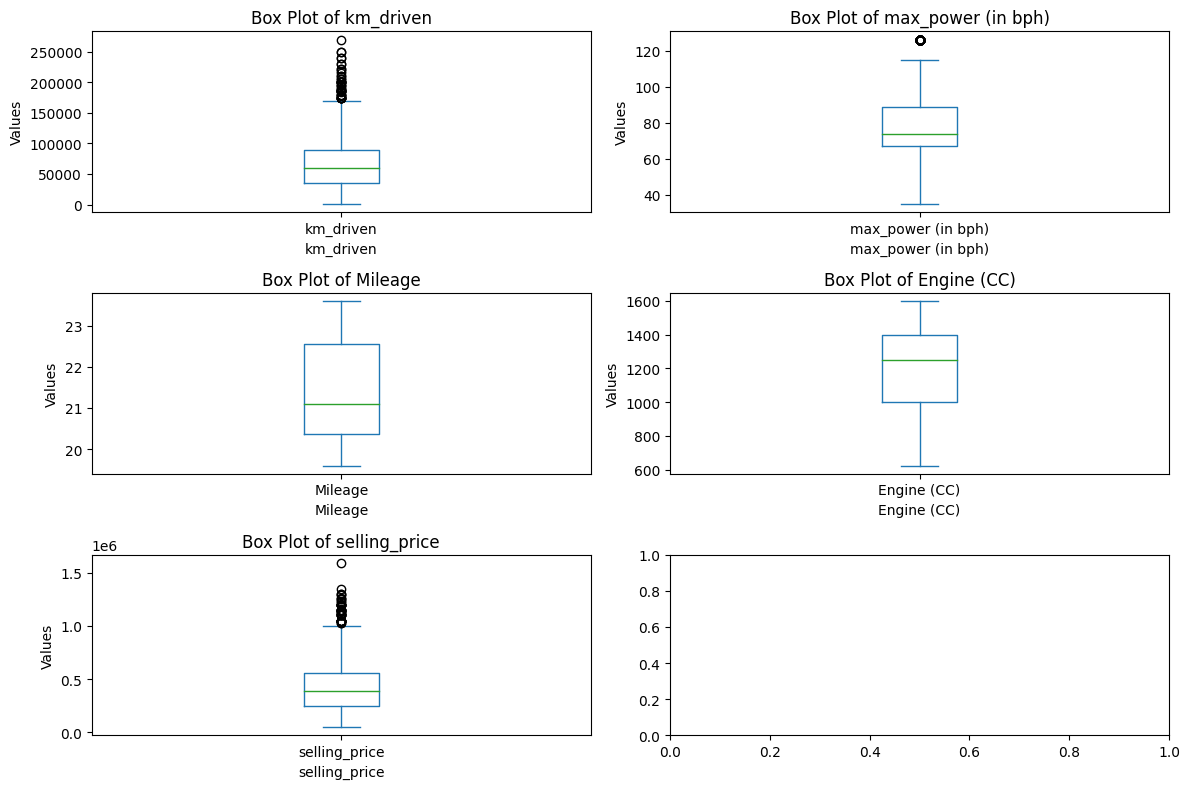

In [13]:
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# Plot box plots for each column
df['km_driven'].plot(kind='box', ax=axs[0, 0])
df['max_power (in bph)'].plot(kind='box', ax=axs[0, 1])
df['Mileage'].plot(kind='box', ax=axs[1, 0])
df['Engine (CC)'].plot(kind='box', ax=axs[1, 1])
df['selling_price'].plot(kind='box', ax=axs[2, 0])

# Set titles and labels
axs[0, 0].set_title('Box Plot of km_driven')
axs[0, 0].set_ylabel('Values')
axs[0, 0].set_xlabel('km_driven')

axs[0, 1].set_title('Box Plot of max_power (in bph)')
axs[0, 1].set_ylabel('Values')
axs[0, 1].set_xlabel('max_power (in bph)')

axs[1, 0].set_title('Box Plot of Mileage')
axs[1, 0].set_ylabel('Values')
axs[1, 0].set_xlabel('Mileage')

axs[1, 1].set_title('Box Plot of Engine (CC)')
axs[1, 1].set_ylabel('Values')
axs[1, 1].set_xlabel('Engine (CC)')

axs[2, 0].set_title('Box Plot of selling_price')
axs[2, 0].set_ylabel('Values')
axs[2, 0].set_xlabel('selling_price')

# Remove white spaces between plots and clear the plt memory
plt.tight_layout()
plt.show()

There are outliers for `km_drive`, `max_power (in bhp)`, and `selling_price`.

During the data cleaning and processing step, the outliers with `km_drive` and `max_power (in bhp)` will need to be addressed since outliers weakens the strength of statistical models. That being said, `selling_price` does not need to be addressed since this variable will be the response variable we want to predict. 

In [14]:
# identify outliers for km_driven
km_q1 = 35000
km_q3 = 90000

km_q1 = df.describe()['km_driven'].iloc[4]
km_q3 = df.describe()['km_driven'].iloc[6]

km_iqr = km_q3 - km_q1

km_upper_limit = km_q3 + 1.5 * km_iqr
print("The upper outlier threshold is,",km_upper_limit)
print()

km_lower_limit = km_q1 - 1.5 * km_iqr
print("The lower outlier threshold is",km_lower_limit)

# filter data where km_driven values is greater than the upper limit
    # or less than the lower limit
km_outliers = df[
                    (df['km_driven'] > km_upper_limit) | 
                    (df['km_driven'] < km_lower_limit)
                        ]
# review results
print(km_outliers.sample(3, random_state = 42))
print('- - - - - - - - - -')

# Num of outliers
km_outliers.shape[0]

The upper outlier threshold is, 172500.0

The lower outlier threshold is -47500.0
      Unnamed: 0      name  year  selling_price  km_driven    fuel  \
1890        5615  Mahindra  2013         250000     180000  Diesel   
1523        4572    Maruti  2013         350000     185000  Diesel   
1528        4601    Maruti  2012         325000     175000  Diesel   

     seller_type transmission         owner  seats  max_power (in bph)  \
1890  Individual       Manual   First Owner      5                64.1   
1523  Individual       Manual   First Owner      5                74.0   
1528  Individual       Manual  Second Owner      5                88.8   

     Mileage Unit  Mileage  Engine (CC)  
1890         kmpl     20.8         1461  
1523         kmpl     23.4         1248  
1528         kmpl     21.5         1248  
- - - - - - - - - -


44

In [15]:
km_outliers = find_outliers('km_driven',df)
km_outliers.head()

Upper outlier threshold: 172500.0
Lower outlier threshold: -47500.0
There are 44 outliers.


,Unnamed: 0,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)
91,276,Maruti,2011,185000,185000,Diesel,Individual,Manual,Third Owner,5,73.90,kmpl,21.10,1248
158,486,Hyundai,2011,400000,221889,Diesel,Dealer,Manual,First Owner,5,126.32,kmpl,22.32,1582
273,866,Maruti,2000,108000,206000,Petrol,Individual,Manual,Fourth & Above Owner,5,46.30,kmpl,19.70,796
317,1002,Maruti,2011,280000,210000,Diesel,Individual,Manual,First Owner,5,74.00,kmpl,22.90,1248
552,1686,Tata,2013,260000,189000,Diesel,Individual,Manual,First Owner,5,88.76,kmpl,21.02,1248


In [16]:
km_outliers = find_outliers('max_power (in bph)',df)

Upper outlier threshold: 121.265
Lower outlier threshold: 34.50500000000001
There are 121 outliers.


In [17]:
km_outliers = find_outliers('Engine (CC)',df)

Upper outlier threshold: 1993.0
Lower outlier threshold: 401.0
There are 0 outliers.


# 2.6 Correlation Analysis

A multicollinearity issue will be raised when a correlation between variables is greater than `|0.80|`.

In [18]:
# Find which columns are numeric
num_cols = df.dtypes[df.dtypes != 'O']
num_cols = num_cols.index
num_cols

Index(['Unnamed: 0', 'year', 'selling_price', 'km_driven', 'seats',
       'max_power (in bph)', 'Mileage', 'Engine (CC)'],
      dtype='object')

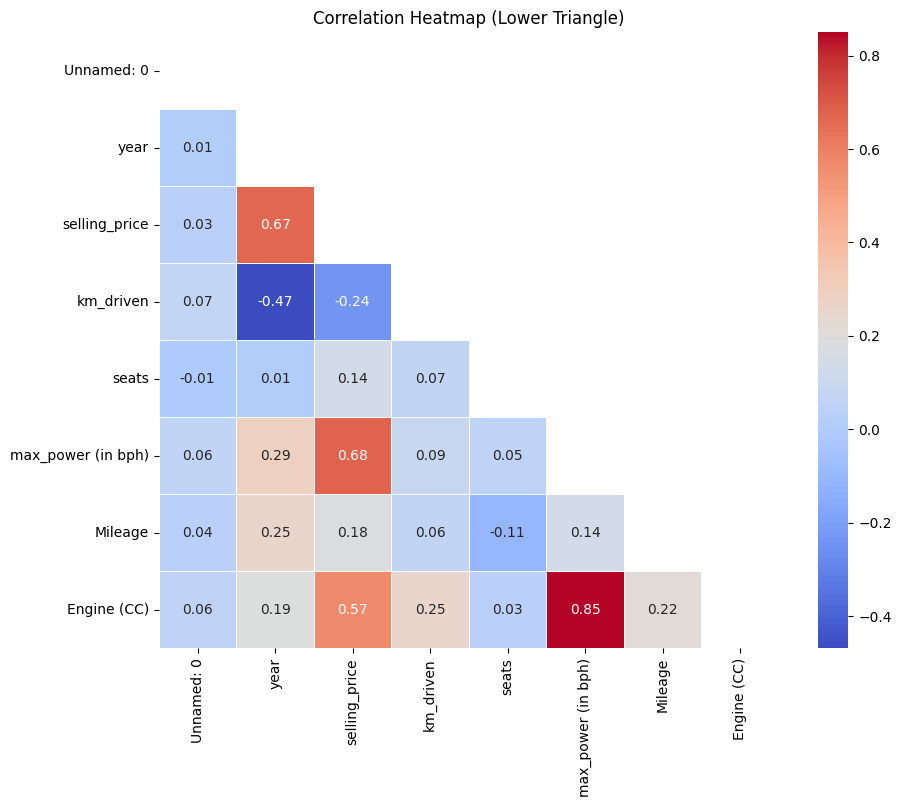

In [19]:
# Calculate the correlation matrix
corr = df[num_cols].corr()

# Generate a mask for the upper triangle
mask = ~np.tri(corr.shape[0], k=-1, dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Lower Triangle)')
plt.show()


`Engine (CC)` and `max_power (in bhp)` has a correlation value of `+0.85`, indicating a strong positive linear relationship between the two variables. This means that as one variable increases, the other variable tends to increase as well, and vice versa. From a statistical standpoint, such strong correlation suggests the potential for multicollinearity, posing a risk of double-counting effects on the response variable. To mitigate this issue and prevent unintended impacts on the response variable, it's advisable to remove one of these variables from the analysis.

In [20]:
df[df['year'] == 2005]

,Unnamed: 0,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)
81,235,Maruti,2005,110000,45000,Petrol,Individual,Manual,Second Owner,5,46.3,kmpl,19.7,796
84,250,Maruti,2005,90000,99361,Petrol,Individual,Manual,Second Owner,5,46.3,kmpl,19.7,796
92,280,Maruti,2005,85000,80000,Petrol,Individual,Manual,Fourth & Above Owner,5,46.3,kmpl,19.7,796
193,616,Maruti,2005,85000,150000,Petrol,Individual,Manual,Second Owner,5,46.3,kmpl,19.7,796
288,919,Maruti,2005,90000,40000,Petrol,Individual,Manual,Second Owner,5,46.3,kmpl,19.7,796
289,920,Maruti,2005,80000,40000,Petrol,Individual,Manual,Second Owner,5,46.3,kmpl,19.7,796
321,1016,Maruti,2005,95000,70000,Petrol,Individual,Manual,Third Owner,5,46.3,kmpl,19.7,796
414,1278,Maruti,2005,90000,100000,Petrol,Individual,Manual,Fourth & Above Owner,5,46.3,kmpl,19.7,796
425,1322,Maruti,2005,180000,49455,Petrol,Individual,Manual,First Owner,5,46.3,kmpl,19.7,796
1327,4018,Maruti,2005,110000,90000,Petrol,Individual,Manual,Second Owner,5,46.3,kmpl,19.7,796


# 2.7 Trends Overview

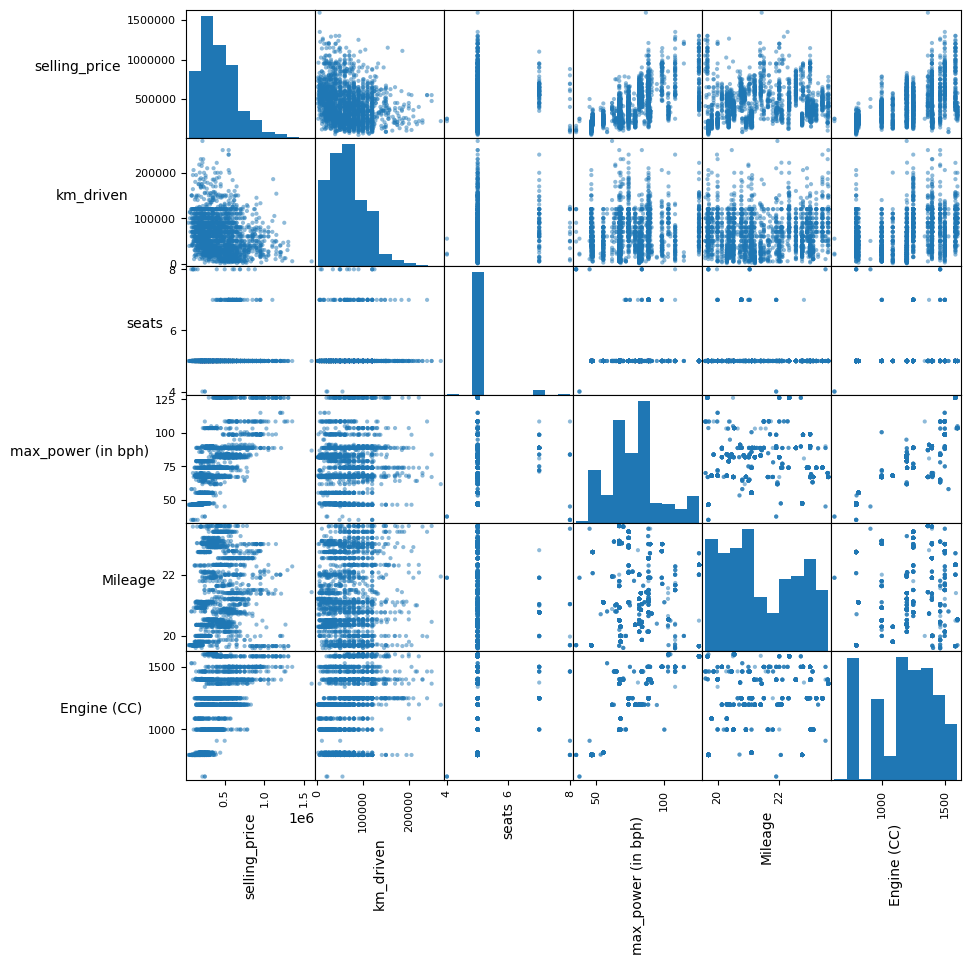

In [21]:
# Specify relevant numerical columns to plot
num_cols = ['selling_price', 'km_driven', 'seats',
       'max_power (in bph)', 'Mileage', 'Engine (CC)']


# Create scatter plot matrix
scatter_matrix = pd.plotting.scatter_matrix(df[num_cols], figsize=(10,10))

# Rotate x-axis labels
for ax in scatter_matrix.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    

plt.show()

**Analysis of Quantitative Features Trends**

- The distribution of `km_driven` is skewed left, indicating that a few vehicles have been driven significantly more kilometers than the median (50th percentile) of the used cars, thereby influencing a higher mean.


- There exists a positive correlation between `Engine (CC)` and `max_power (in bph)` with selling price. As both `Engine (CC)` and `max_power (in bph)` increase, so does the selling price. This observation aligns with our correlation analysis. 
    - However, the relationship between `Engine (CC)` and selling price appears more pronounced compared to `max_power (in bhp)` and selling price. Moreover, considering that `Engine (CC)` lacks outliers while `max_power (in bhp)` has 120 outliers, it is advisable to exclude `max_power (in bhp)` for a cleaner analysis.


- Upon visual inspection, it is evident that the data points for `km_driven` and `selling_price` exhibit clustering in certain regions. Further investigation into these clusters is warranted.

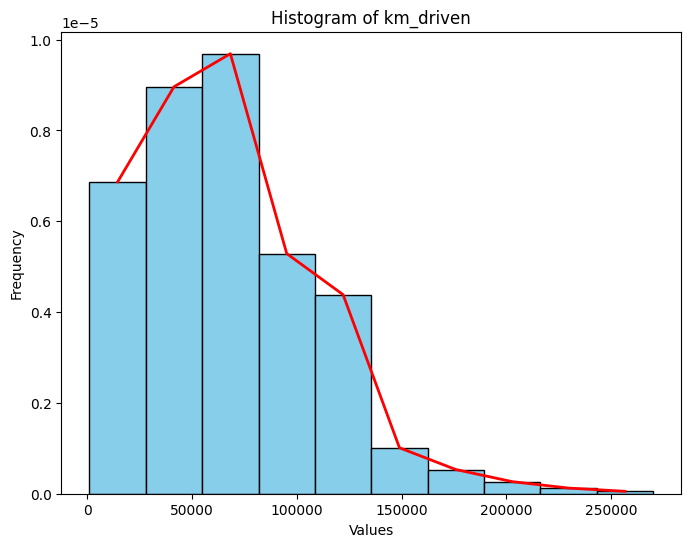

In [22]:
# Histogram for km_driven
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(df['km_driven'], bins=10, color='skyblue', edgecolor='black', density=True)
plt.title('Histogram of ' + 'km_driven')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Plot a line following the curve of the histogram
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.plot(bin_centers, n, color='red', linestyle='-', linewidth=2)


`km_driven` is skewed left. There is a small number of used cars with an extremely high number of kilometers on the car.

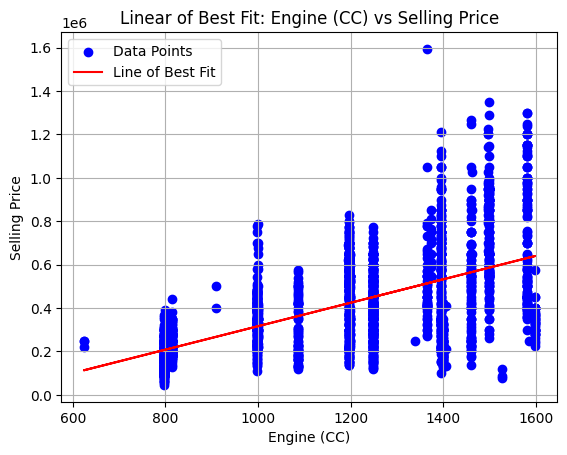

In [23]:
# Extract x and y values from the DataFrame
x = df['Engine (CC)']
y = df['selling_price']

# Perform linear regression to find the line of best fit
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the y values for the line of best fit
line_of_best_fit = slope * x + intercept

# Plot the points
plt.scatter(x, y, color='blue', label='Data Points')

# Plot the line of best fit
plt.plot(x, line_of_best_fit, color='red', label='Line of Best Fit')

# Add labels and legend
plt.xlabel('Engine (CC)')
plt.ylabel('Selling Price')
plt.title('Linear of Best Fit: Engine (CC) vs Selling Price')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

`Engine (CC)` and `selling_price` has a positive line of best fit.

Optimal number of clusters: 2


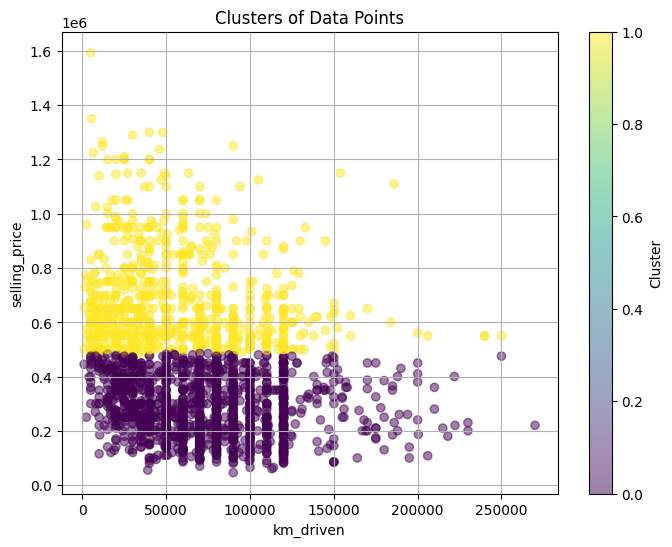

In [24]:
# Numerical columns of interest for clusters
X = df[['km_driven', 'selling_price']]

# Initialize variables
best_score = -1
best_n_clusters = 0

# Try different numbers of clusters
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=5)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, labels)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

print("Optimal number of clusters:", best_n_clusters)

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=5)
kmeans.fit(X)
labels = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X['km_driven'], X['selling_price'], c=labels, cmap='viridis', alpha=0.5)
plt.title('Clusters of Data Points')
plt.xlabel('km_driven')
plt.ylabel('selling_price')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


Two clusters between `km_driven` and `selling_price` have been clearly defined by the `KMeans` clustering model. These clusters can be confidently used as features to strengthen our model.

**Analysis of Qualitative Features Trends**

In [25]:
# make a new copy of the dataframe
cat_analysis_df = df.copy()

# make year a categorical variable for plotting
cat_analysis_df['year'] = cat_analysis_df['year'].apply( lambda x : str(x))

# find categorical variables
cat_cols = cat_analysis_df.dtypes[cat_analysis_df.dtypes == 'O']
cat_cols = cat_cols.index 
cat_cols

Index(['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner',
       'Mileage Unit'],
      dtype='object')

In [26]:
cat_df = cat_analysis_df[cat_cols]
cat_df

,name,year,fuel,seller_type,transmission,owner,Mileage Unit
0,Maruti,2014,Diesel,Individual,Manual,First Owner,kmpl
1,Hyundai,2010,Diesel,Individual,Manual,First Owner,kmpl
2,Hyundai,2017,Petrol,Individual,Manual,First Owner,kmpl
3,Toyota,2011,Diesel,Individual,Manual,First Owner,kmpl
4,Ford,2013,Diesel,Individual,Manual,First Owner,kmpl
...,...,...,...,...,...,...,...
2090,Maruti,2017,Petrol,Individual,Manual,First Owner,kmpl
2091,Toyota,2014,Diesel,Individual,Manual,First Owner,kmpl
2092,Maruti,2011,Petrol,Individual,Manual,First Owner,kmpl
2093,Maruti,2017,Petrol,Individual,Manual,First Owner,kmpl


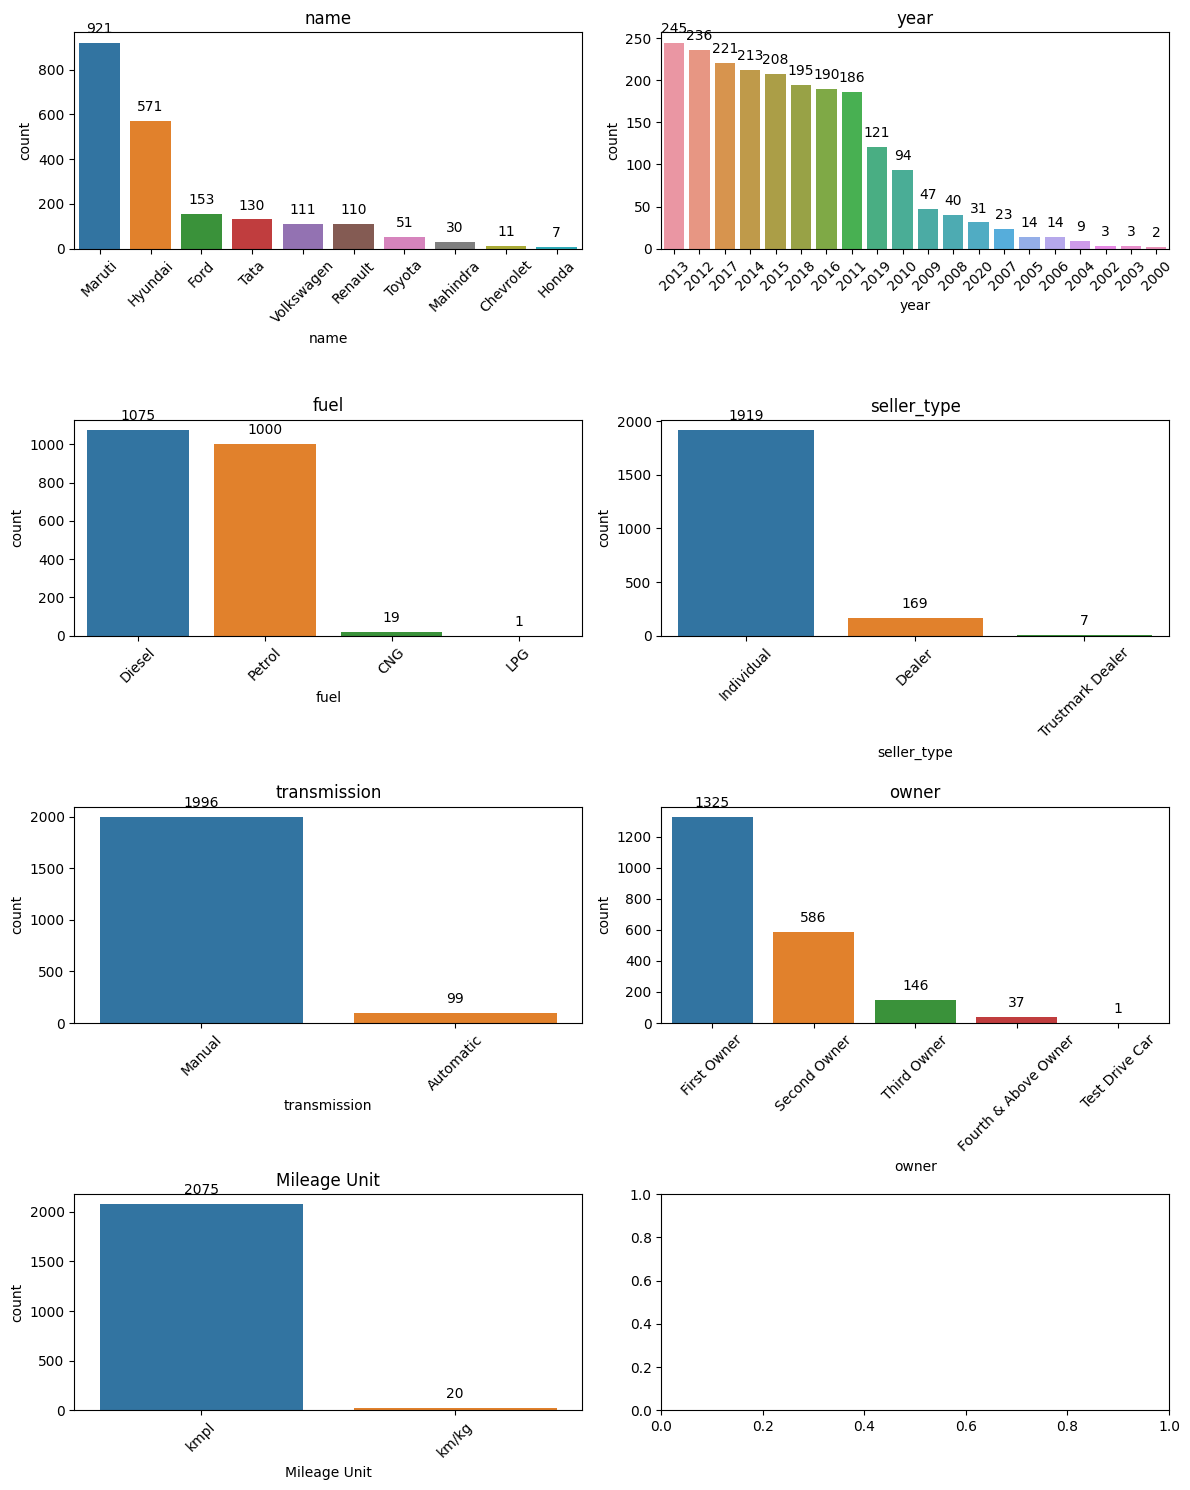

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame containing the data
# Assuming 'cat_cols' is a list containing the names of the categorical columns

# Define the number of rows and columns for the subplot grid
rows = 4
cols = 2

# Create a subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(12, 15))

# Flatten the subplot grid to iterate over each axis
axes = axes.flatten()

# Iterate over each categorical column
for i, col in enumerate(cat_cols):
    # Count the unique values in the column
    value_counts = cat_df[col].value_counts()
    
    # Plot the bar plot
    sns.barplot(x=value_counts.index, y=value_counts, ax=axes[i])
    
    # Add count of each bar at the top
    for p in axes[i].patches:
        axes[i].annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points')
    
    # Set the title for each subplot
    axes[i].set_title(col)
    
    # Rotate x-axis labels for better readability if necessary
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plots
plt.show()


- The top 3 selling brands are Maruti, Hyundai, and Ford, respectively.
- The top 3 selling car manufacture years is 2013, 2012, and 2017, respectively.
- The majority of sellers are first owners by individuals with manual cars.

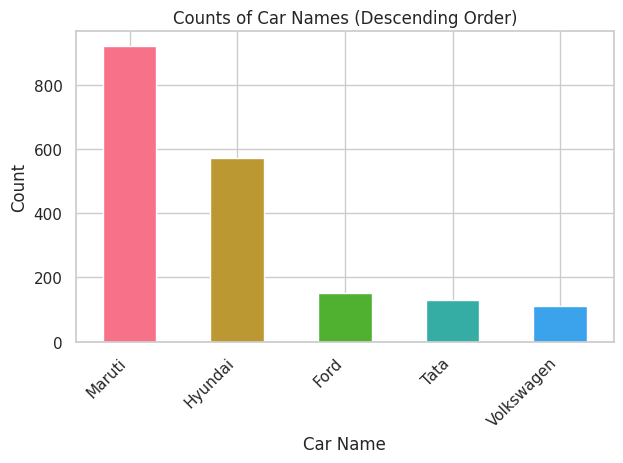

In [28]:
# Set the seaborn style and color palette
sns.set(style="whitegrid", palette="husl")

# Calculate the counts of each car name
name_counts = cat_df['name'].value_counts().sort_values(ascending=False)

# Show only the top 5
name_counts = name_counts.head()

# Create the bar plot
name_counts.plot(kind='bar', color=sns.color_palette())
plt.title('Counts of Car Names (Descending Order)')
plt.xlabel('Car Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Maruti, Hyundai, and Ford are the top selling brands.

In [29]:
# Explode the 'name' column to create one row per car name
cat_df_exploded = cat_df.explode('name')

# Create the pivot table
pivot_table = pd.pivot_table(cat_df, values='name', index='year', aggfunc='count')

# Sort the pivot table in descending order
pivot_table.sort_values(by='name', ascending=False).head()


,name
year,
2013,245
2012,236
2017,221
2014,213
2015,208


The top 3 selling manufacture years is 2013, 2012, 2017.

In [30]:
# Concatenate 'seller_type', 'owner', and 'transmission' columns into a single column
cat_df_exploded['group'] = cat_df_exploded['seller_type'] + ' ' + cat_df_exploded['owner'] + ' ' + cat_df_exploded['transmission']

# Create the pivot table
pivot_table = pd.pivot_table(cat_df_exploded, values='year', index=['group'], columns='name', aggfunc='count', fill_value=0)

pivot_table['row_sum'] = pivot_table.sum(axis=1)

# Rearrange the columns to have the new column come first
pivot_table = pivot_table[['row_sum'] + [col for col in pivot_table.columns if col != 'row_sum']]

# Sort the DataFrame by the values in the 'row_sum' column in descending order
pivot_table.sort_values(by='row_sum', ascending=False).head()

name,row_sum,Chevrolet,Ford,Honda,Hyundai,Mahindra,Maruti,Renault,Tata,Toyota,Volkswagen
group,,,,,,,,,,,
Individual First Owner Manual,1108,6,77,3,307,14,463,67,96,30,45
Individual Second Owner Manual,553,4,36,1,171,12,241,21,22,12,33
Individual Third Owner Manual,144,0,5,0,35,1,81,5,3,3,11
Dealer First Owner Manual,124,1,22,2,34,3,39,12,1,4,6
Individual First Owner Automatic,67,0,0,0,9,0,46,1,5,0,6


The table highlights that the majority of sales are attributed to first owners of manual cars, representing over half of the total sales volume.

# 3.0 Cleaning Data Preparation for ML Modelling

In [31]:
# the dataframe we will use for cleaning
global clean_df
clean_df = df.copy()

# 3.1 Clean Year

In [32]:
print(min(clean_df['year']))

# reduce year value by 2000
clean_df['year'] = clean_df['year'] - 2000

clean_df.head()

2000


,Unnamed: 0,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)
0,0,Maruti,14,450000,145500,Diesel,Individual,Manual,First Owner,5,74.00,kmpl,23.40,1248
1,2,Hyundai,10,225000,127000,Diesel,Individual,Manual,First Owner,5,90.00,kmpl,23.00,1396
2,4,Hyundai,17,440000,45000,Petrol,Individual,Manual,First Owner,5,81.86,kmpl,20.14,1197
3,7,Toyota,11,350000,90000,Diesel,Individual,Manual,First Owner,5,67.10,kmpl,23.59,1364
4,8,Ford,13,200000,169000,Diesel,Individual,Manual,First Owner,5,68.10,kmpl,20.00,1399


- The reference point will be the year 2000, serving as our starting time at 0 and year 2020 will be at time 20.

- This designation is significant as the column relates to time, a crucial aspect of our analysis.

# 3.2 Clean Unnecessary Columns

In [33]:
clean_df.columns

Index(['Unnamed: 0', 'name', 'year', 'selling_price', 'km_driven', 'fuel',
       'seller_type', 'transmission', 'owner', 'seats', 'max_power (in bph)',
       'Mileage Unit', 'Mileage', 'Engine (CC)'],
      dtype='object')

In [34]:
clean_df = clean_df.drop(['Unnamed: 0', 'max_power (in bph)'], axis = 1)
clean_df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,Mileage Unit,Mileage,Engine (CC)
0,Maruti,14,450000,145500,Diesel,Individual,Manual,First Owner,5,kmpl,23.40,1248
1,Hyundai,10,225000,127000,Diesel,Individual,Manual,First Owner,5,kmpl,23.00,1396
2,Hyundai,17,440000,45000,Petrol,Individual,Manual,First Owner,5,kmpl,20.14,1197
3,Toyota,11,350000,90000,Diesel,Individual,Manual,First Owner,5,kmpl,23.59,1364
4,Ford,13,200000,169000,Diesel,Individual,Manual,First Owner,5,kmpl,20.00,1399


- dropped Unnamed: 0 since there is no meaning to a unique identifier

- dropped max_power (in bhp) since
    1. it has a very strong correlation with Engine (CC)
    2. has outliers whereas Engine (CC) does not have outliers

In [35]:
# Percentage of different values
clean_df['Mileage Unit'].value_counts() / clean_df.shape[0]

Mileage Unit
kmpl     0.990453
km/kg    0.009547
Name: count, dtype: float64

`Mileage Unit` is 99% the same value. This does not provide value information for the model's learning. Therefore this will also be removed.

In [36]:
clean_df = clean_df.drop('Mileage Unit', axis=1)
clean_df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,Mileage,Engine (CC)
0,Maruti,14,450000,145500,Diesel,Individual,Manual,First Owner,5,23.40,1248
1,Hyundai,10,225000,127000,Diesel,Individual,Manual,First Owner,5,23.00,1396
2,Hyundai,17,440000,45000,Petrol,Individual,Manual,First Owner,5,20.14,1197
3,Toyota,11,350000,90000,Diesel,Individual,Manual,First Owner,5,23.59,1364
4,Ford,13,200000,169000,Diesel,Individual,Manual,First Owner,5,20.00,1399


# 3.3 Clean Outliers

In [37]:
km_outliers = find_outliers('km_driven', df=clean_df)

km_outlier_idx = km_outliers.index
km_outlier_idx

Upper outlier threshold: 172500.0
Lower outlier threshold: -47500.0
There are 44 outliers.


Index([  91,  158,  273,  317,  552,  621,  790,  795,  802,  888,  924,  957,
       1053, 1083, 1176, 1286, 1308, 1325, 1349, 1353, 1425, 1472, 1477, 1515,
       1523, 1528, 1550, 1565, 1574, 1581, 1681, 1721, 1724, 1726, 1775, 1868,
       1878, 1890, 1932, 1947, 1948, 1988, 2075, 2084],
      dtype='int64')

In [38]:
# Replace the outliers with the upper threshold to strengthen models learning
clean_df.loc[km_outlier_idx, 'km_driven'] = 172500

# Check results have been replced correctly
clean_df.iloc[km_outlier_idx].head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,Mileage,Engine (CC)
91,Maruti,11,185000,172500,Diesel,Individual,Manual,Third Owner,5,21.10,1248
158,Hyundai,11,400000,172500,Diesel,Dealer,Manual,First Owner,5,22.32,1582
273,Maruti,0,108000,172500,Petrol,Individual,Manual,Fourth & Above Owner,5,19.70,796
317,Maruti,11,280000,172500,Diesel,Individual,Manual,First Owner,5,22.90,1248
552,Tata,13,260000,172500,Diesel,Individual,Manual,First Owner,5,21.02,1248


- The outliers for `km_driven` has been updated to become the upper thresholds.

- Note the outliers from max_power does not need to be updated since that column has been removed.

# 3.4 Standardization

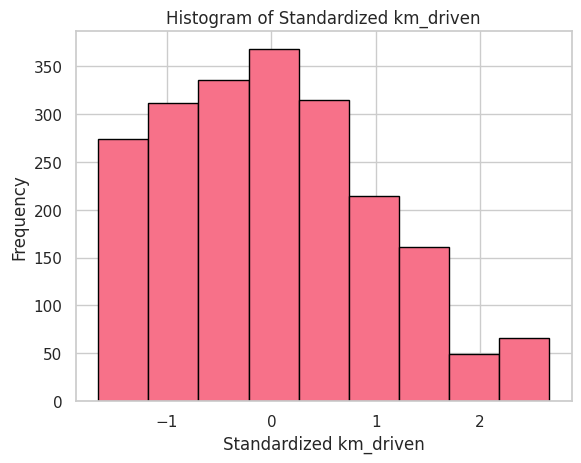

In [39]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data and transform it
scaled_data = scaler.fit_transform(clean_df[['km_driven']])

# Update the 'km_driven' column with the scaled values
clean_df['km_driven'] = scaled_data

# Plot a histogram of the standardized 'km_driven' column
plt.hist(clean_df['km_driven'], bins=9, edgecolor='black')
plt.xlabel('Standardized km_driven')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized km_driven')
plt.show()

- `km_driven` has been standardized.

- The other variables was not standardized since it either held a time series value or it was an item characteristic.

# 3.5 Clean Categorical Features

**Convert transmission values to boolean, [0,1]**

In [40]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'transmission' column
clean_df['transmission'] = label_encoder.fit_transform(clean_df['transmission'])

print("Label meanings for 'transmission':")
for label, meaning in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{meaning}: {label}")

# Check Results
clean_df.sample(6, random_state = 1)


Label meanings for 'transmission':
0: Automatic
1: Manual


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,Mileage,Engine (CC)
859,Volkswagen,17,575000,-0.675907,Diesel,Individual,1,First Owner,5,21.66,1498
1233,Tata,16,400000,0.836297,Diesel,Individual,1,First Owner,5,22.95,1248
2013,Maruti,14,325000,-0.040680,Petrol,Trustmark Dealer,0,First Owner,5,23.10,998
1680,Maruti,14,465000,0.584263,Diesel,Individual,1,First Owner,5,23.40,1248
1939,Hyundai,10,350000,0.584263,Diesel,Individual,1,Second Owner,5,23.00,1396
1881,Maruti,17,725000,-0.801924,Petrol,Individual,0,First Owner,5,21.21,1197


**Owner has numerical significance**

In [41]:
clean_df['owner'].value_counts()

owner
First Owner             1325
Second Owner             586
Third Owner              146
Fourth & Above Owner      37
Test Drive Car             1
Name: count, dtype: int64

**Convert transmission values to boolean, [0. 1]**

Label meanings for 'transmission':

0: Automatic

1: Manual

In [42]:
# Apply the function to clean the column called owner
clean_df['owner'] = clean_df['owner'].apply(clean_owner)

# Verify the results are correct
clean_df['owner'].value_counts()

owner
1    1325
2     586
3     146
4      37
0       1
Name: count, dtype: int64

The categorical variable `owner` was changed to a numeric variable because it has numerical meaning.

**One Hot Encode the remaining categorical variables**

In [43]:
# Select the columns to encode
columns_to_encode = ['name', 'fuel', 'seller_type']

# Initialize the OneHotEncoder and output a dense matrix
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the selected columns
encoded_data = encoder.fit_transform(clean_df[columns_to_encode])

# Create a DataFrame from the encoded data with column names
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

# Concatenate encoded DataFrame with the original DataFrame, excluding the columns that were encoded
clean_df = pd.concat([clean_df.drop(columns=columns_to_encode), encoded_df], axis=1)

# Display the final DataFrame
clean_df


,year,selling_price,km_driven,transmission,owner,seats,Mileage,Engine (CC),name_Chevrolet,name_Ford,...,name_Tata,name_Toyota,name_Volkswagen,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer
0,14,450000,1.983053,1,1,5,23.40,1248,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,10,225000,1.516789,1,1,5,23.00,1396,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,17,440000,-0.549890,1,1,5,20.14,1197,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,11,350000,0.584263,1,1,5,23.59,1364,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,13,200000,2.575333,1,1,5,20.00,1399,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090,17,425000,-1.381603,1,1,5,23.10,998,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2091,14,425000,-0.423873,1,1,5,23.59,1364,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2092,11,200000,0.155805,1,1,5,19.70,796,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2093,17,360000,0.332229,1,1,5,20.51,998,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [44]:
clean_df.columns

Index(['year', 'selling_price', 'km_driven', 'transmission', 'owner', 'seats',
       'Mileage', 'Engine (CC)', 'name_Chevrolet', 'name_Ford', 'name_Honda',
       'name_Hyundai', 'name_Mahindra', 'name_Maruti', 'name_Renault',
       'name_Tata', 'name_Toyota', 'name_Volkswagen', 'fuel_CNG',
       'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol', 'seller_type_Dealer',
       'seller_type_Individual', 'seller_type_Trustmark Dealer'],
      dtype='object')

After cleaning the categorical variables, 11 features have been increased to 25 features.

# 4.0 Feature Engineering

It was previously shown there were 2 definite clusters between `km_drive` and `selling_price`.

Optimal number of clusters: 10


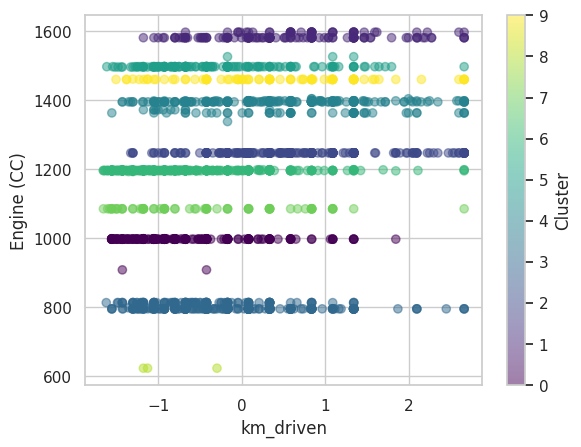

[2 4 6 ... 3 0 4]


In [45]:
km_driven_engine_clusters = cluster_and_plot(['km_driven', 'Engine (CC)'],clean_df)
print(km_driven_engine_clusters)

There are 10 well defined clusters between `km_driven` and `Engine (CC)`.


Optimal number of clusters: 2


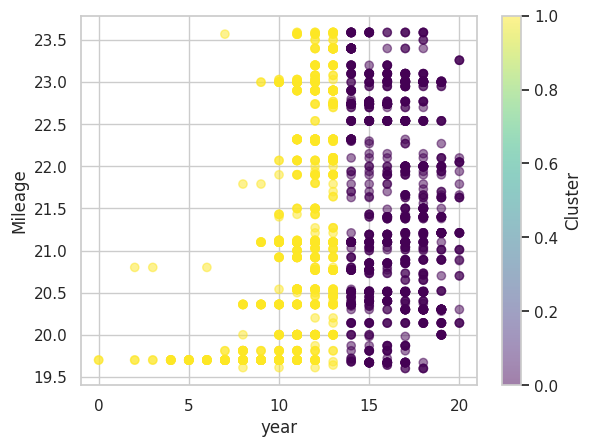

array([0, 1, 0, ..., 1, 0, 0], dtype=int32)

In [46]:
year_milage_clusters = cluster_and_plot(['year', 'Mileage'],clean_df)
year_milage_clusters

There are 2 well defined clusters between `year` and `Mileage`.

In [47]:
# Add clusters to dataset
clean_df['year_milage_clusters'] = year_milage_clusters
clean_df['km_driven_engine_clusters'] = km_driven_engine_clusters

In [48]:
# Verify Results
clean_df.head()

,year,selling_price,km_driven,transmission,owner,seats,Mileage,Engine (CC),name_Chevrolet,name_Ford,...,name_Volkswagen,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,year_milage_clusters,km_driven_engine_clusters
0,14,450000,1.983053,1,1,5,23.40,1248,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,2
1,10,225000,1.516789,1,1,5,23.00,1396,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,4
2,17,440000,-0.549890,1,1,5,20.14,1197,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,6
3,11,350000,0.584263,1,1,5,23.59,1364,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,4
4,13,200000,2.575333,1,1,5,20.00,1399,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,4


# 5.0 Train Test Split

After splitting the data into training and testing sets, it's essential to reconsolidate and execute all prior cleaning and feature engineering procedures exclusively on the training dataset.

In [49]:
df

,Unnamed: 0,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)
0,0,Maruti,2014,450000,145500,Diesel,Individual,Manual,First Owner,5,74.00,kmpl,23.40,1248
1,2,Hyundai,2010,225000,127000,Diesel,Individual,Manual,First Owner,5,90.00,kmpl,23.00,1396
2,4,Hyundai,2017,440000,45000,Petrol,Individual,Manual,First Owner,5,81.86,kmpl,20.14,1197
3,7,Toyota,2011,350000,90000,Diesel,Individual,Manual,First Owner,5,67.10,kmpl,23.59,1364
4,8,Ford,2013,200000,169000,Diesel,Individual,Manual,First Owner,5,68.10,kmpl,20.00,1399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090,6245,Maruti,2017,425000,12000,Petrol,Individual,Manual,First Owner,5,67.04,kmpl,23.10,998
2091,6246,Toyota,2014,425000,50000,Diesel,Individual,Manual,First Owner,5,67.06,kmpl,23.59,1364
2092,6249,Maruti,2011,200000,73000,Petrol,Individual,Manual,First Owner,5,46.30,kmpl,19.70,796
2093,6253,Maruti,2017,360000,80000,Petrol,Individual,Manual,First Owner,5,67.04,kmpl,20.51,998


In [50]:
drop_unnecessary_cols(df)

X = df.drop('selling_price', axis = 1)
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
X_train

,Unnamed: 0,name,year,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)
30,88,Maruti,2019,10000,Petrol,Individual,Manual,First Owner,5,81.80,kmpl,21.21,1197
1178,3567,Maruti,2016,35000,Petrol,Individual,Manual,First Owner,5,47.30,kmpl,22.74,796
1628,4865,Maruti,2005,50800,Petrol,Dealer,Manual,Second Owner,5,46.30,kmpl,19.70,796
764,2360,Maruti,2016,120000,Diesel,Individual,Manual,Third Owner,5,73.94,kmpl,23.20,1248
1317,3996,Maruti,2013,63000,Diesel,Individual,Manual,First Owner,5,74.00,kmpl,23.40,1248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,4894,Hyundai,2016,49200,Petrol,Individual,Manual,First Owner,5,55.20,kmpl,21.10,814
1095,3329,Volkswagen,2014,111000,Diesel,Individual,Manual,First Owner,5,103.20,kmpl,20.34,1498
1130,3438,Hyundai,2012,40000,Petrol,Individual,Manual,First Owner,5,78.90,kmpl,20.36,1197
1294,3908,Maruti,2019,20000,Petrol,Individual,Automatic,First Owner,5,83.10,kmpl,21.40,1197


Created a function to consolidate the cleaning process and feature engineering which can be applied to the training data.

In [52]:
X_train

,Unnamed: 0,name,year,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)
30,88,Maruti,2019,10000,Petrol,Individual,Manual,First Owner,5,81.80,kmpl,21.21,1197
1178,3567,Maruti,2016,35000,Petrol,Individual,Manual,First Owner,5,47.30,kmpl,22.74,796
1628,4865,Maruti,2005,50800,Petrol,Dealer,Manual,Second Owner,5,46.30,kmpl,19.70,796
764,2360,Maruti,2016,120000,Diesel,Individual,Manual,Third Owner,5,73.94,kmpl,23.20,1248
1317,3996,Maruti,2013,63000,Diesel,Individual,Manual,First Owner,5,74.00,kmpl,23.40,1248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,4894,Hyundai,2016,49200,Petrol,Individual,Manual,First Owner,5,55.20,kmpl,21.10,814
1095,3329,Volkswagen,2014,111000,Diesel,Individual,Manual,First Owner,5,103.20,kmpl,20.34,1498
1130,3438,Hyundai,2012,40000,Petrol,Individual,Manual,First Owner,5,78.90,kmpl,20.36,1197
1294,3908,Maruti,2019,20000,Petrol,Individual,Automatic,First Owner,5,83.10,kmpl,21.40,1197


Upper outlier threshold: 172500.0
Lower outlier threshold: -47500.0
There are 38 outliers.
Optimal number of clusters: 10


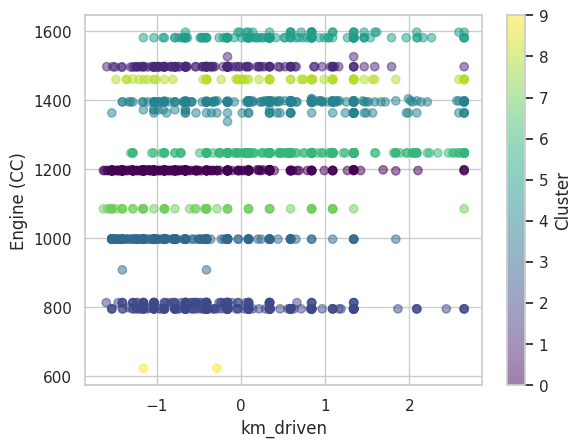

Optimal number of clusters: 2


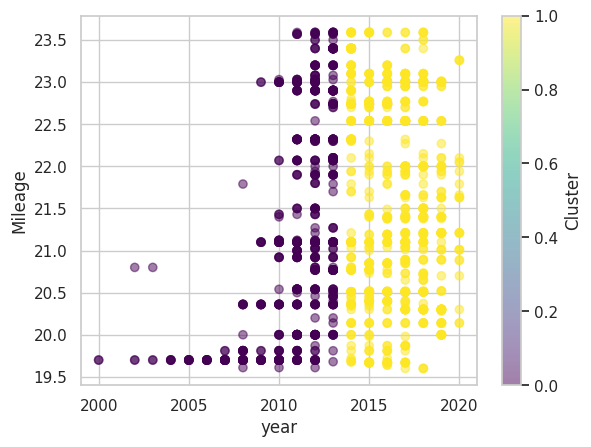

Upper outlier threshold: 171000.0
Lower outlier threshold: -45000.0
There are 6 outliers.
Optimal number of clusters: 7


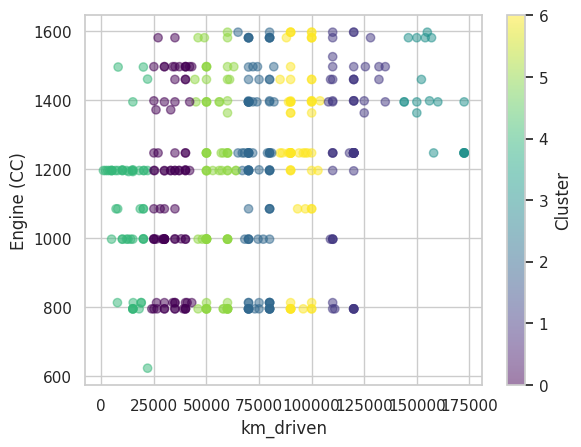

Optimal number of clusters: 2


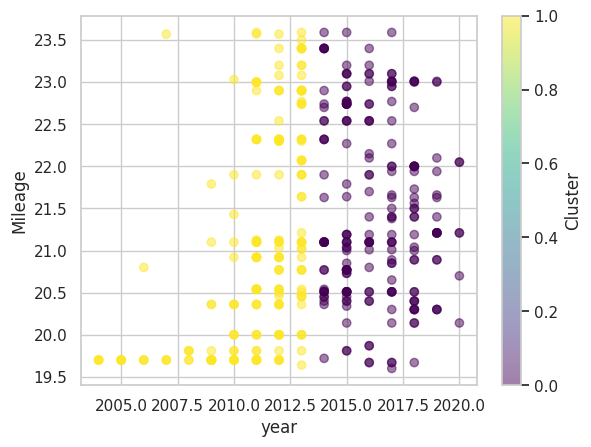

In [53]:
# Training
X_train_prepared = prepare_train_data(X_train.copy())

# Testing
X_test_prepared = prepare_test_data(X_test.copy())

In [54]:
X_train_prepared.head()

,year,km_driven,transmission,owner,seats,Mileage,Engine (CC),name_Chevrolet,name_Ford,name_Honda,...,name_Volkswagen,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,km_driven_engine_clusters,year_milage_clusters
30,19,-1.411110,Manual,1,5,21.21,1197,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1
1178,16,-0.786439,Manual,1,5,22.74,796,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2,1
1628,5,-0.391648,Manual,2,5,19.70,796,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2,0
764,16,1.337440,Manual,3,5,23.20,1248,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6,1
1317,13,-0.086808,Manual,1,5,23.40,1248,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6,0


In [55]:
X_test_prepared.head()

,year,km_driven,transmission,owner,seats,Mileage,Engine (CC),km_driven_engine_clusters,year_milage_clusters,name_Chevrolet,...,name_Tata,name_Toyota,name_Volkswagen,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer
210,17,-0.161769,Manual,1,5,19.67,1582,5,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1169,17,-0.411637,Manual,1,5,22.95,1248,5,0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1146,17,-1.036307,Manual,1,5,21.63,998,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
879,17,-0.661505,Manual,1,5,20.30,1199,0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
29,9,0.263007,Manual,2,5,21.79,998,2,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
